In [88]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hydra import initialize, compose
from lenstronomy.Plots import plot_util
from glob import glob
import PIL
import matplotlib.patches as patches
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot, plot_util
from mejiro.lenses import lens_util
from mejiro.utils import util

In [121]:
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.lenses.test import SampleStrongLens

roman = Roman()
lens = SampleStrongLens()
bands = ['F106', 'F129', 'F184']
scene_size = 5  # arcsec
oversample = 5
exposure_time = 146

lens_macromodel = deepcopy(lens)
realization = util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'))
lens.add_subhalos(realization)

psfs = []
for band in bands:
    files = glob(f'{repo_dir}/tests/test_data/{band.upper()}_*.npy')
    print(files)
    psf_file = files[0]
    if psf_file is not None:
        psfs.append(np.load(psf_file))

exposures = []
exposures_macromodel = []
for band, psf in zip(bands, psfs):
    synthetic_image = SyntheticImage(strong_lens=lens, 
                                        instrument=roman, 
                                        band=band, 
                                        arcsec=scene_size, 
                                        oversample=oversample)
    synth_macromodel = SyntheticImage(strong_lens=lens_macromodel, 
                                        instrument=roman, 
                                        band=band, 
                                        arcsec=scene_size, 
                                        oversample=oversample)

    exposure = Exposure(synthetic_image, 
                            exposure_time=exposure_time,
                            psf=psf)
    
    poisson_noise = exposure.poisson_noise
    reciprocity_failure = exposure.reciprocity_failure
    dark_noise = exposure.dark_noise
    nonlinearity = exposure.nonlinearity
    ipc = exposure.ipc
    read_noise = exposure.read_noise
    all_noise = poisson_noise + reciprocity_failure + dark_noise + nonlinearity + ipc + read_noise

    engine_params = {
        'poisson_noise': poisson_noise,
        'reciprocity_failure': reciprocity_failure,
        'dark_noise': dark_noise,
        'nonlinearity': nonlinearity,
        'ipc': ipc,
        'read_noise': read_noise
    }

    exposure_macromodel = Exposure(synth_macromodel,
                                   exposure_time=exposure_time,
                                   engine_params=engine_params,
                                   psf=psf)
    
    exposures.append(exposure.exposure)
    exposures_macromodel.append(exposure_macromodel.exposure)

['/nfshome/bwedig/mejiro/tests/test_data/F106_1_2048_2048_5_101.npy']
['/nfshome/bwedig/mejiro/tests/test_data/F129_1_2048_2048_5_101.npy']
['/nfshome/bwedig/mejiro/tests/test_data/F184_1_2048_2048_5_101.npy']
Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band
Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pi

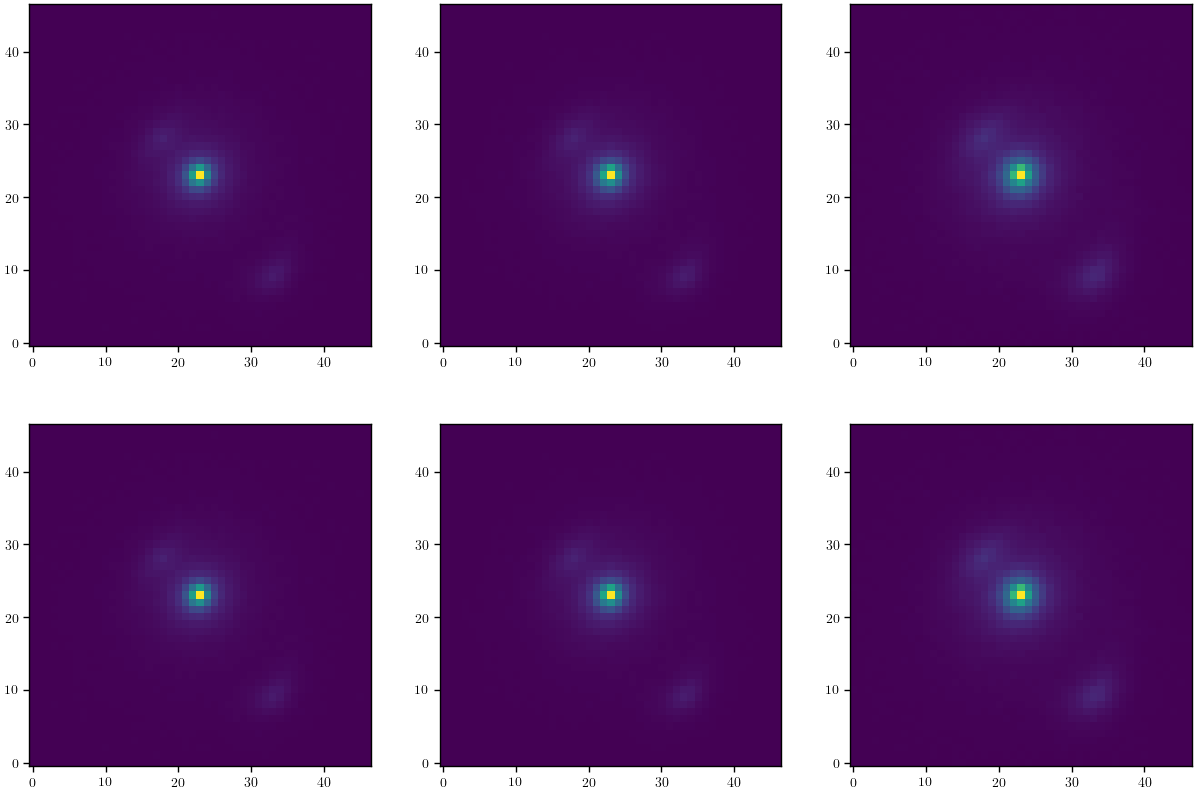

In [84]:
exposures = [i / 146 for i in exposures]
exposures_macromodel = [i / 146 for i in exposures_macromodel]

_, ax = plt.subplots(2, 3, figsize=(15, 10))

all_exposures = exposures + exposures_macromodel
for i, a in enumerate(ax.flatten()):
    a.imshow(all_exposures[i])

In [ ]:
figure_cache_dir = os.path.join(figure_dir, 'cartoon')
util.create_directory_if_not_exists(figure_cache_dir)

for band, exposure in zip(bands, exposures):
    np.save(os.path.join(figure_cache_dir, f'exposure_{band}.npy'), exposure)

for band, exposure in zip(bands, exposures_macromodel):
    np.save(os.path.join(figure_cache_dir, f'exposure_macromodel_{band}.npy'), exposure)

util.pickle(os.path.join(figure_cache_dir, 'sample_strong_lens.pkl'), lens)
util.pickle(os.path.join(figure_cache_dir, 'sample_strong_lens_macromodel.pkl'), lens_macromodel)
util.pickle(os.path.join(figure_cache_dir, 'noise.pkl'), all_noise)

In [ ]:
exposures = [np.load(f) for f in sorted(glob(f'{figure_cache_dir}/exposure_F*.npy'))]
assert len(exposures) == 3

exposures_macromodel = [np.load(f) for f in sorted(glob(f'{figure_cache_dir}/exposure_macromodel_*.npy'))]
assert len(exposures_macromodel) == 3

lens = util.unpickle(os.path.join(figure_cache_dir, 'sample_strong_lens.pkl'))
assert lens is not None

lens_macromodel = util.unpickle(os.path.join(figure_cache_dir, 'sample_strong_lens_macromodel.pkl'))
assert lens_macromodel is not None

all_noise = util.unpickle(os.path.join(figure_cache_dir, 'noise.pkl'))
assert all_noise is not None

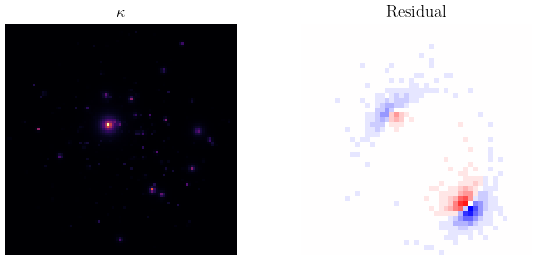

In [171]:
# plot kappa and residual

kappa = lens.get_subhalo_kappa(num_pix=100, side=10)
residual = exposures[0] - exposures_macromodel[0]

f, ax = plt.subplots(1, 2, figsize=(7, 3))

norm = colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=kappa.min(), vmax=kappa.max())
ax[0].imshow(kappa, cmap='inferno', norm=norm)
ax[0].set_title(r'$\kappa$')
ax[1].imshow(residual, cmap='bwr', norm=colors.CenteredNorm())
ax[1].set_title('Residual')

for a in ax:
    a.axis('off')

plt.savefig(os.path.join(figure_cache_dir, 'kappa_residual.png'))
plt.show()

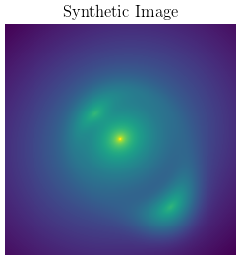

In [172]:
# plot synthetic image

plt.figure(figsize=(3, 3))
plt.imshow(np.log10(synthetic_image.image))
plt.axis('off')
plt.title('Synthetic Image')
plt.savefig(os.path.join(figure_cache_dir, 'synthetic_image.png'))
plt.show()

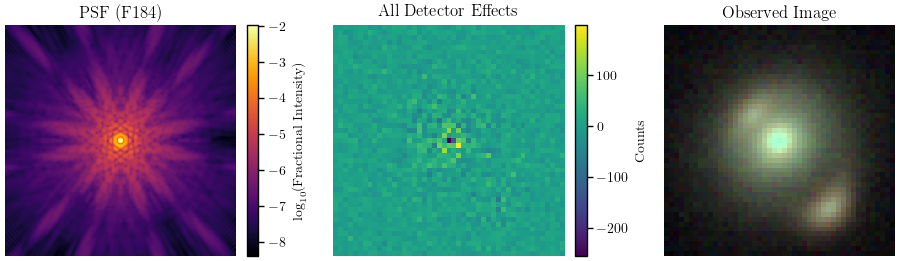

In [173]:
# plot PSF, detector effects, and observed image

from mejiro.helpers import color

f, ax = plt.subplots(1, 3, figsize=(12, 3))

im = ax[0].imshow(np.log10(psfs[2]), cmap='inferno')
ax[0].set_title('PSF (F184)')
cbar = plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
cbar.set_label(r'$\log_{10}(\textrm{Fractional Intensity})$')
im = ax[1].imshow(all_noise.array, cmap='viridis')
cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label(r'Counts')
ax[1].set_title('All Detector Effects')
ax[2].imshow(color.get_rgb(image_b=exposures[0] / exposure_time, image_g=exposures[1] / exposure_time, image_r=exposures[2] / exposure_time, stretch=4, Q=6))
ax[2].set_title('Observed Image')

for a in ax:
    a.axis('off')

plt.savefig(os.path.join(figure_cache_dir, 'psf_detector_effects_observed_image.png'))
plt.show()

In [72]:
# f, ax = plt.subplots(figsize=(7, 4), dpi=600)
# ax.set_axis_off()

# # set colors
# line_color = 'grey'
# marker_color = 'grey'

# # draw redshift axis


# # add source plane
# source_plane = np.flipud(np.asarray(PIL.Image.open(os.path.join(figure_cache_dir, 'source.png'))))
# ax_image = f.add_axes([0.1,0.7,0.3,0.3], anchor='SW', zorder=0)
# ax_image.imshow(source_plane)
# ax_image.set_xticks([])
# ax_image.set_yticks([])
# ax_image.set_axis_off()

# # add lens plane
# lens_plane = np.flipud(np.asarray(PIL.Image.open(os.path.join(figure_cache_dir, 'image.png'))))
# ax_image = f.add_axes([0.4,0.4,0.3,0.3], anchor='SW', zorder=1)
# ax_image.imshow(lens_plane)
# ax_image.set_xticks([])
# ax_image.set_yticks([])
# ax_image.set_axis_off()

# # add subhalos
# subhalos = np.flipud(np.asarray(PIL.Image.open(os.path.join(figure_cache_dir, 'subhalo_3d.png')))
# )
# ax_image = f.add_axes([0.4,0.4,0.3,0.3], anchor='SW', zorder=0)
# ax_image.imshow(lens_plane)
# ax_image.set_xticks([])
# ax_image.set_yticks([])
# ax_image.set_axis_off()

# # add Roman
# roman = np.flipud(np.asarray(PIL.Image.open(os.path.join(figure_cache_dir, 'roman.png'))))
# ax_image = f.add_axes([0.8,0.1,0.3,0.3], anchor='SW', zorder=0)
# ax_image.imshow(roman)
# ax_image.set_xticks([])
# ax_image.set_yticks([])
# ax_image.set_axis_off()

# # draw light rays TODO do in powerpoint? such a pain to do in Python
# # ax.annotate('', xy=(0.45, 0.45), xytext=(0.1, 0.9),
# #             arrowprops=dict(arrowstyle='-|>', color=line_color, zorder=2))

# # image_coords = (901, 954)
# # circ_image = patches.Circle(image_coords, radius=20, color=marker_color)
# # _ = ax.add_patch(circ_image)
# # ax_image = f.add_axes([0.39,0.03,0.2,0.2], anchor='NE', zorder=1)  # 0.425,0
# # ax_image.imshow(residual_default, cmap='bwr', norm=norm)
# # ax_image.spines[:].set_linewidth(2.)
# # ax_image.spines[:].set_color(line_color)
# # ax_image.set_xticks([])
# # ax_image.set_yticks([])
# # con_image_b = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_image.transData, xyB=image_coords, coordsB=ax.transData, linewidth=2, color=line_color)
# # con_image_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_image.transData, xyB=image_coords, coordsB=ax.transData, linewidth=2, color=line_color)
# # ax.add_artist(con_image_b)
# # ax.add_artist(con_image_t)

# plt.savefig(os.path.join(figure_dir, 'cartoon.png'))
# plt.show()